Found 18317 images belonging to 3 classes.
Found 3857 images belonging to 3 classes.
Found 1929 images belonging to 3 classes.
Tên các lớp: ['0_normal', '1_covid19', '2_Pneumonia']
Class Weights: {0: 0.9567011386190327, 1: 0.9559521945618704, 2: 1.1005167027156932}
Epoch 1/100
1145/1145 [==============================] - ETA: 0s - loss: 0.8689 - accuracy: 0.6264
Epoch 1: val_accuracy improved from -inf to 0.73995, saving model to E:/lv/VGG19\best_model.h5
1145/1145 [==============================] - 284s 238ms/step - loss: 0.8689 - accuracy: 0.6264 - val_loss: 0.6729 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 2/100
1145/1145 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7410
Epoch 2: val_accuracy improved from 0.73995 to 0.78714, saving model to E:/lv/VGG19\best_model.h5
1145/1145 [==============================] - 262s 229ms/step - loss: 0.6616 - accuracy: 0.7410 - val_loss: 0.5699 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 3/100
1145/1145 [============

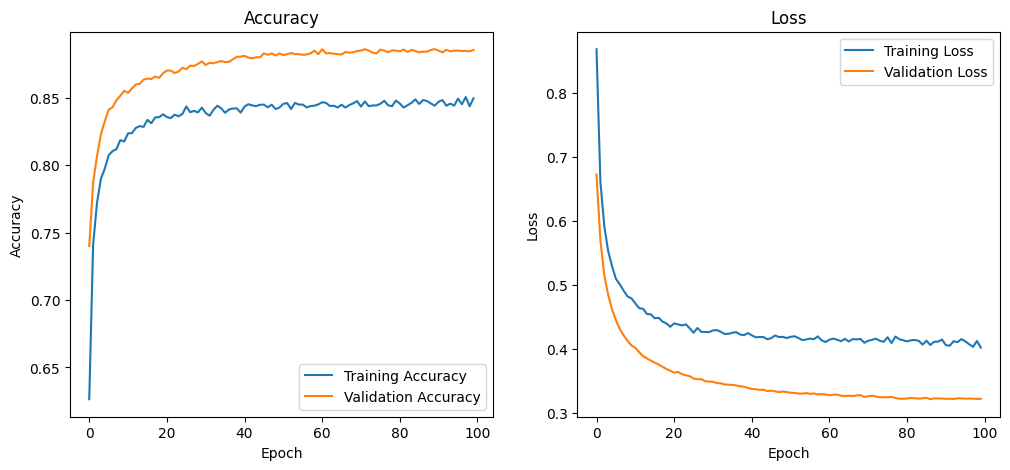

121/121 [==============================] - 27s 224ms/step - loss: 0.3419 - accuracy: 0.8751
Test Accuracy: 0.88
Test Loss: 0.34
121/121 [==============================] - 22s 184ms/step


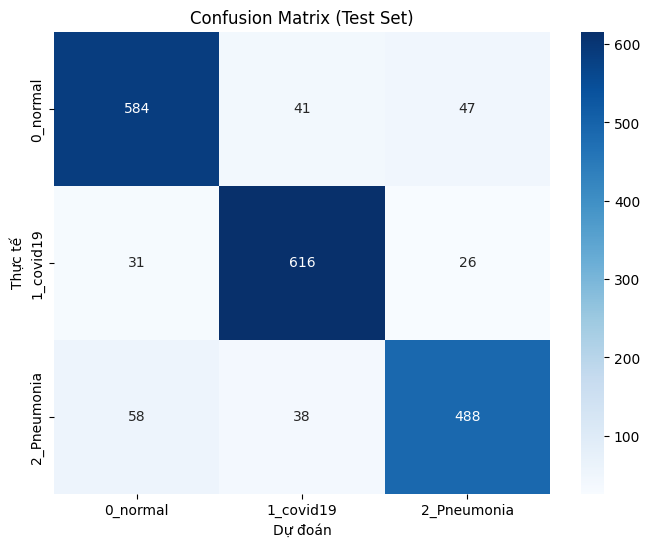

Classification Report (Test Set):
              precision    recall  f1-score   support

    0_normal       0.87      0.87      0.87       672
   1_covid19       0.89      0.92      0.90       673
 2_Pneumonia       0.87      0.84      0.85       584

    accuracy                           0.88      1929
   macro avg       0.87      0.87      0.87      1929
weighted avg       0.87      0.88      0.87      1929



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 8
NUM_CLASSES = 3  


train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,                
    horizontal_flip=True,          
    rotation_range=5               

)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_dataset = train_datagen.flow_from_directory(
    'D:/x-ray_split/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1
)

val_dataset = val_test_datagen.flow_from_directory(
    'D:/x-ray_split/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1,
    shuffle=False
)

test_dataset = val_test_datagen.flow_from_directory(
    'D:/x-ray_split/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1,
    shuffle=False  
)

class_names = list(train_dataset.class_indices.keys())
print("Tên các lớp:", class_names)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Xây dựng mô hình với VGG19
def build_model(num_classes):
    inputs = keras.Input(shape=(IMAGE_LEN, IMAGE_LEN, 3))

    base_model = VGG19(include_top=False, input_tensor=inputs, weights='imagenet')
    base_model.trainable = False  

    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.05, name='top_dropout')(x) 
    outputs = keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)

    model = tf.keras.Model(inputs, outputs, name='vgg19')

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = build_model(NUM_CLASSES)

checkpoint = ModelCheckpoint(
    filepath='E:/lv/VGG19/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=4, 
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[checkpoint, lr_scheduler],
    verbose=1,
    class_weight=class_weights  
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.2f}')

# Ma trận nhầm lẫn trên tập test
true_labels = test_dataset.classes
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# Báo cáo phân loại chi tiết
print("Classification Report (Test Set):")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

model.save('E:/lv/VGG19/last_model_100e.h5')

Found 1929 images belonging to 3 classes.
242/242 [==============================] - 31s 127ms/step - loss: 0.3419 - accuracy: 0.8751
Test Accuracy: 0.8751
Test Loss: 0.3419
242/242 [==============================] - 31s 127ms/step


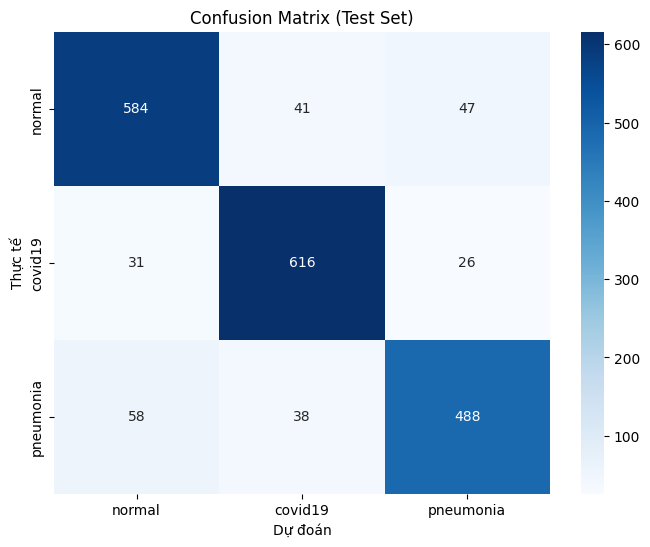

Classification Report (Test Set):
              precision    recall  f1-score   support

      normal     0.8678    0.8690    0.8684       672
     covid19     0.8863    0.9153    0.9006       673
   pneumonia     0.8699    0.8356    0.8524       584

    accuracy                         0.8751      1929
   macro avg     0.8747    0.8733    0.8738      1929
weighted avg     0.8749    0.8751    0.8748      1929



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Định nghĩa các tham số
IMAGE_LEN = 224
IMAGE_SIZE = (IMAGE_LEN, IMAGE_LEN)
BATCH_SIZE = 8

class_names = ['normal', 'covid19', 'pneumonia']  

val_test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = val_test_datagen.flow_from_directory(
    'D:/x-ray_split/test',  
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

model = load_model('E:/lv/VGG19/last_model_100e.h5')

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Dự đoán nhãn trên tập test
true_labels = test_dataset.classes
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Ma trận nhầm lẫn trên tập test
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

print("Classification Report (Test Set):")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))
